# Max Law Neural Network Predictor

The goal is to study the architecture of a neural network and its performance on a specific dataset.

The dataset we are going to define here is made of synthetic data and the goal is to predict the maximum value among N inputs (N=5) where each input is an integer in a limited range (0 to max_value-1).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')

from Helpers.NeuralNetwork import NeuralNetwork

from Helpers import Helpers
from Layers.FullyConnected import FullyConnected
from Layers.Activations import ReLU
from Layers.Activations import SoftMax
from Layers.BatchNormalization import BatchNormalization
from Layers.Dropout import Dropout
from Layers.Initializers import He, Constant

from Optimization.Optimizers import Adam
from Optimization.Loss import CrossEntropyLoss
from Optimization.Constraints import L2_Regularizer

# For reproducibility
np.random.seed(42)

## 1. Creating a Data Layer for the Maximum Problem with Integer Values

In [4]:
# Definition of a data layer compatible with the modularyNN framework
class MaxLawDataLayer:
    def __init__(self, num_samples, input_dim, max_value=10, batch_size=32, balanced=True):
        self.batch_size = batch_size
        self.current_idx = 0
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.max_value = max_value
        
        # Create a balanced dataset if requested
        if balanced:
            self.create_balanced_dataset()
        else:
            self.create_random_dataset()
        
        # Split 80% training and 20% validation
        self.train_indices = np.random.choice(num_samples, int(0.8 * num_samples), replace=False)
        self.val_indices = np.array([i for i in range(num_samples) if i not in self.train_indices])
    
    def create_random_dataset(self):
        """Create a dataset with random integers"""
        # Generate input data - random integers between 0 and max_value-1
        self.input_tensor = np.random.randint(0, self.max_value, (self.num_samples, self.input_dim))
        
        # Calculate outputs (maximum value for each sample)
        self.max_indices = np.max(self.input_tensor, axis=1)
        
        # Convert to one-hot encoding for classification
        self.label_tensor = np.zeros((self.num_samples, self.max_value))
        for i, max_idx in enumerate(self.max_indices):
            self.label_tensor[i, max_idx] = 1
    
    def create_balanced_dataset(self):
        """Create a dataset with balanced classes (equal number of each maximum value)"""
        # Initialize arrays
        self.input_tensor = np.zeros((self.num_samples, self.input_dim), dtype=int)
        self.max_indices = np.zeros(self.num_samples, dtype=int)
        
        # Calculate samples per class
        samples_per_class = self.num_samples // self.max_value
        
        for max_val in range(self.max_value):
            # Get indices for this class
            start_idx = max_val * samples_per_class
            end_idx = (max_val + 1) * samples_per_class if max_val < self.max_value - 1 else self.num_samples
            
            for i in range(start_idx, end_idx):
                # Create a sample where the maximum value is max_val
                # First, fill with random values less than max_val
                if max_val > 0:  # For max_val = 0, all inputs must be 0
                    self.input_tensor[i] = np.random.randint(0, max_val, self.input_dim)
                else:
                    self.input_tensor[i] = np.zeros(self.input_dim, dtype=int)
                    
                # Then, ensure at least one input equals max_val
                if max_val > 0:  # Skip this step for max_val = 0 (already all zeros)
                    random_position = np.random.randint(0, self.input_dim)
                    self.input_tensor[i, random_position] = max_val
                
                # Set the max_index
                self.max_indices[i] = max_val
        
        # Shuffle the data to mix classes
        shuffle_indices = np.random.permutation(self.num_samples)
        self.input_tensor = self.input_tensor[shuffle_indices]
        self.max_indices = self.max_indices[shuffle_indices]
        
        # Convert to one-hot encoding for classification
        self.label_tensor = np.zeros((self.num_samples, self.max_value))
        for i, max_idx in enumerate(self.max_indices):
            self.label_tensor[i, max_idx] = 1
    
    def next(self):
        """Return the next batch of training data"""
        if self.current_idx + self.batch_size >= len(self.train_indices):
            self.current_idx = 0
            # Shuffle training data at each epoch
            np.random.shuffle(self.train_indices)
        
        batch_indices = self.train_indices[self.current_idx:self.current_idx + self.batch_size]
        batch_input = self.input_tensor[batch_indices]
        batch_label = self.label_tensor[batch_indices]
        self.current_idx += self.batch_size
        
        return batch_input, batch_label
    
    def get_train_set(self):
        """Return the entire training set"""
        return self.input_tensor[self.train_indices], self.label_tensor[self.train_indices]
    
    def get_validation_set(self):
        """Return the entire validation set"""
        if len(self.val_indices) > 0:
            return self.input_tensor[self.val_indices], self.label_tensor[self.val_indices]
        else:
            return None, None

# Define parameters
N_INPUTS = 5       # Number of inputs
MAX_VALUE = 10     # Maximum possible value (0-9)
N_TRAIN = 5000     # Size of training and validation sets combined
N_TEST = 500       # Size of test set
BATCH_SIZE = 32    # Batch size
USE_BALANCED = True  # Use a balanced dataset

# Create datasets
data_layer = MaxLawDataLayer(N_TRAIN, N_INPUTS, MAX_VALUE, BATCH_SIZE, balanced=USE_BALANCED)
test_data = MaxLawDataLayer(N_TEST, N_INPUTS, MAX_VALUE, BATCH_SIZE, balanced=USE_BALANCED)

# Check the split between training and validation
X_train, y_train = data_layer.get_train_set()
X_val, y_val = data_layer.get_validation_set()
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Check class distribution in training data
train_max_values = np.argmax(y_train, axis=1)
class_counts = np.bincount(train_max_values, minlength=MAX_VALUE)
print("\nClass distribution in training data:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples ({count/len(X_train)*100:.1f}%)")

# Display a few examples
X_batch, y_batch = data_layer.next()
print("\nData examples:")
for i in range(5):
    inputs = X_batch[i]
    max_value = np.argmax(y_batch[i])
    print(f"Inputs: {inputs}, Maximum: {max_value}")

Training samples: 4000
Validation samples: 1000

Class distribution in training data:
Class 0: 408 samples (10.2%)
Class 1: 407 samples (10.2%)
Class 2: 396 samples (9.9%)
Class 3: 404 samples (10.1%)
Class 4: 405 samples (10.1%)
Class 5: 395 samples (9.9%)
Class 6: 400 samples (10.0%)
Class 7: 386 samples (9.7%)
Class 8: 399 samples (10.0%)
Class 9: 400 samples (10.0%)

Data examples:
Inputs: [1 0 0 0 0], Maximum: 1
Inputs: [2 0 4 1 1], Maximum: 4
Inputs: [9 6 8 2 0], Maximum: 9
Inputs: [5 4 6 5 4], Maximum: 6
Inputs: [0 3 7 0 4], Maximum: 7


## 2. Data Visualization

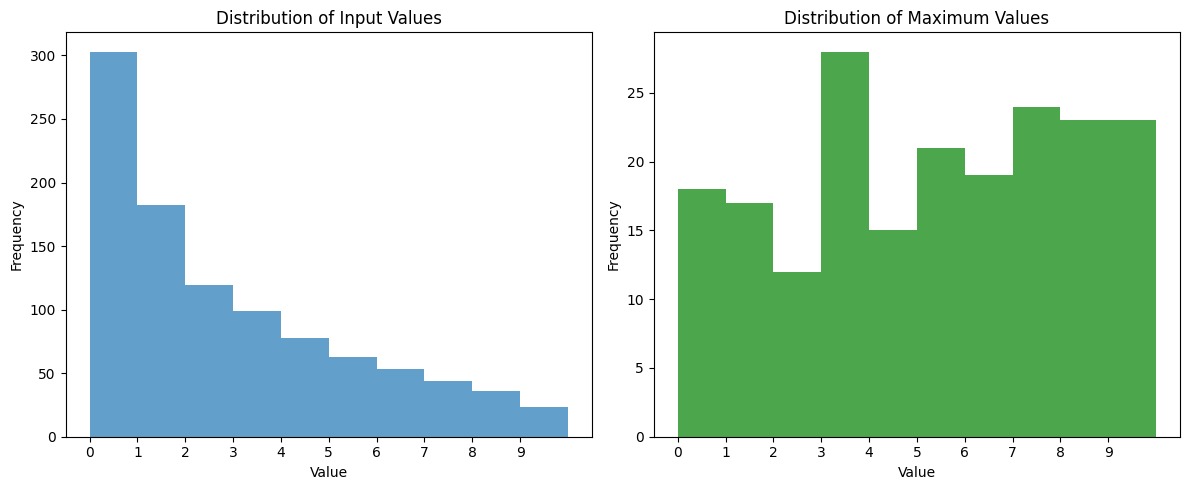

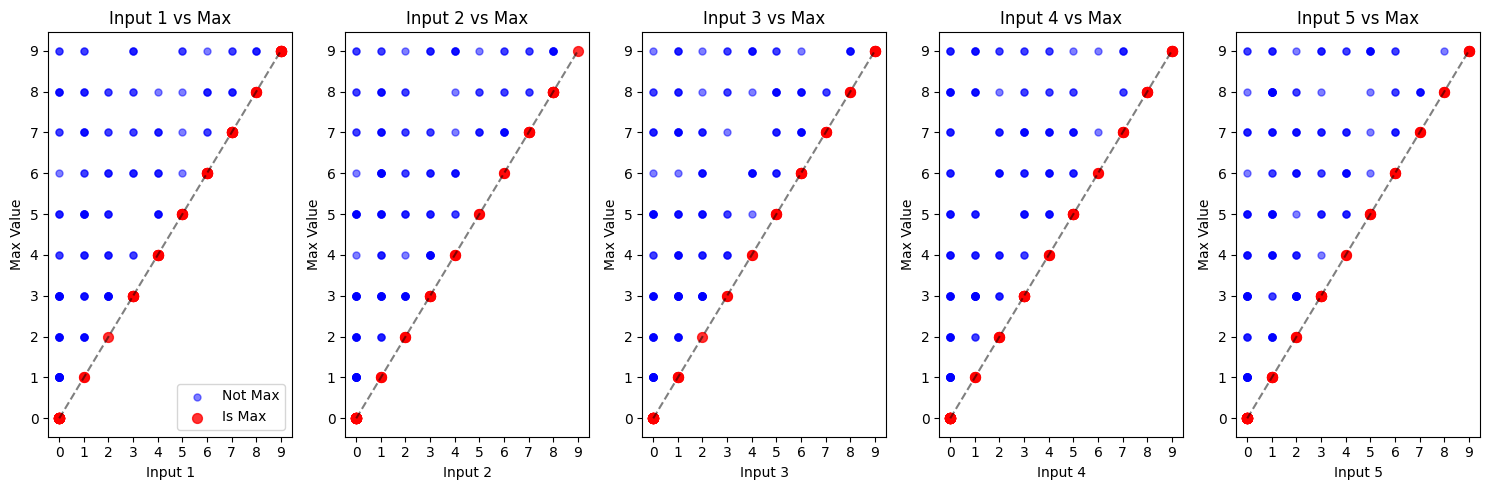

In [5]:
# Select a sample for visualization
sample_size = 200
X_train, y_train = data_layer.get_train_set()
max_indices = np.argmax(y_train, axis=1)

indices = np.random.choice(len(X_train), min(sample_size, len(X_train)), replace=False)
inputs = X_train[indices]
maxs = max_indices[indices]

# Plot distribution of inputs and maximums
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(inputs.flatten(), bins=range(MAX_VALUE+1), alpha=0.7)
plt.title('Distribution of Input Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(MAX_VALUE))

plt.subplot(1, 2, 2)
plt.hist(maxs, bins=range(MAX_VALUE+1), alpha=0.7, color='green')
plt.title('Distribution of Maximum Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(MAX_VALUE))

plt.tight_layout()
plt.show()

# Plot relationship between each input and the maximum value
plt.figure(figsize=(15, 5))
for i in range(N_INPUTS):
    plt.subplot(1, N_INPUTS, i+1)
    
    # Points where this dimension is the maximum will be highlighted
    is_max = inputs[:, i] == maxs
    
    # Plot non-max points
    plt.scatter(inputs[~is_max, i], maxs[~is_max], alpha=0.5, label='Not Max', color='blue', s=25)
    
    # Plot max points
    plt.scatter(inputs[is_max, i], maxs[is_max], alpha=0.8, label='Is Max', color='red', s=50)
    
    # Add y=x line
    min_val, max_val = 0, MAX_VALUE-1
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    plt.title(f'Input {i+1} vs Max')
    plt.xlabel(f'Input {i+1}')
    plt.ylabel('Max Value')
    plt.xticks(range(MAX_VALUE))
    plt.yticks(range(MAX_VALUE))
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## 3. Creating the Neural Network

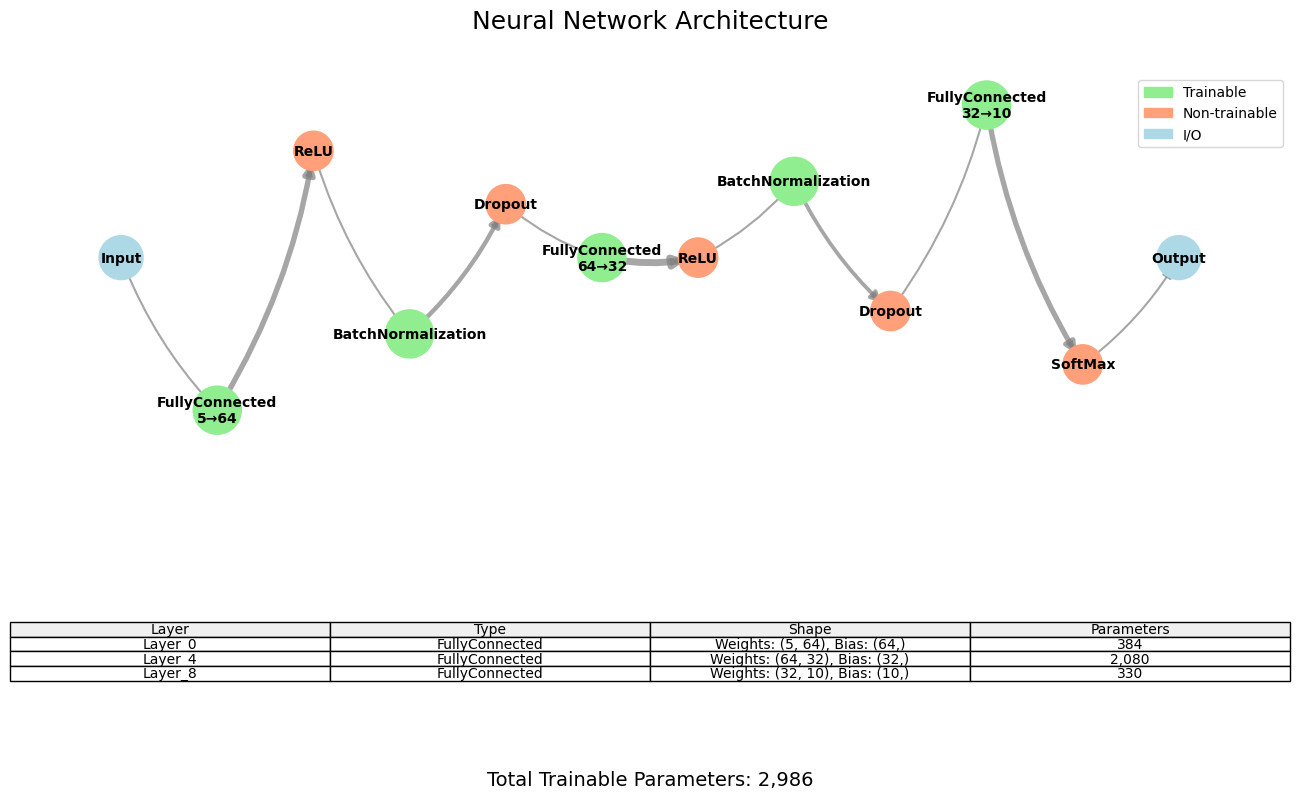

In [6]:
# Network parameters
learning_rate = 0.001
hidden_layers = [64, 32]  # Size of hidden layers - increased for better learning
use_batch_norm = True
dropout_rate = 0.3  # Increased dropout to prevent overfitting

# Network initialization
optimizer = Adam(learning_rate)
weights_initializer = He()  # He initialization suitable for ReLU
bias_initializer = Constant(0.1)

# Add L2 regularization
regularizer = L2_Regularizer(alpha=0.0001)
optimizer.add_regularizer(regularizer)

net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
net.data_layer = data_layer

# Build network architecture
prev_dim = N_INPUTS

# Add hidden layers
for layer_size in hidden_layers:
    net.append_layer(FullyConnected(prev_dim, layer_size))
    net.append_layer(ReLU())
    
    if use_batch_norm:
        net.append_layer(BatchNormalization(layer_size))
        
    if dropout_rate > 0:
        net.append_layer(Dropout(dropout_rate))
        
    prev_dim = layer_size

# Output layer (one output per possible max value)
net.append_layer(FullyConnected(prev_dim, MAX_VALUE))
net.append_layer(SoftMax())  # SoftMax for classification

# Use Cross Entropy Loss for classification
net.loss_layer = CrossEntropyLoss()

# Visualize network architecture
fig = net.plot()

## 4. Training the Network

Training the network for 40 epochs (5000 total iterations)...

Détection automatique du type de problème: classification (basé sur CrossEntropyLoss)
Validation set detected and will be used for display.
 Iteration |         Loss |  Train Acc (%) |  Val Acc (%) | Elapsed Time
-----------------------------------------------------------------
         0 |   146.591716 |          13.60 |        14.50 | 0.00s
        10 |   105.893075 |          13.30 |        13.30 | 0.02s
        20 |   136.845825 |          12.80 |        12.90 | 0.04s
        30 |   126.057874 |          14.00 |        14.50 | 0.05s
        40 |   116.038777 |          16.10 |        15.00 | 0.07s
        50 |    98.743805 |          24.60 |        23.00 | 0.08s
        60 |   141.337821 |          23.10 |        21.30 | 0.10s
        70 |   110.191125 |          24.50 |        23.80 | 0.11s
        80 |   101.903821 |          27.30 |        26.60 | 0.13s
        90 |   113.814314 |          26.10 |        24.40 | 0.14

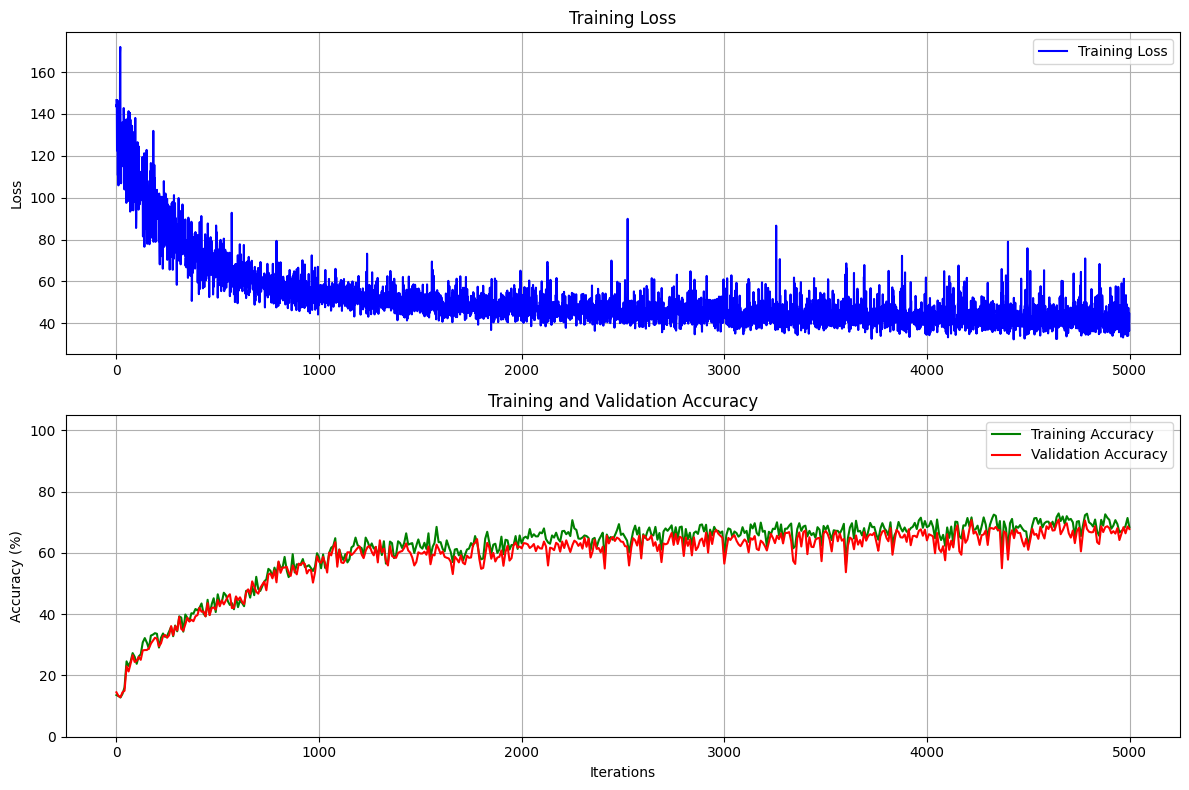

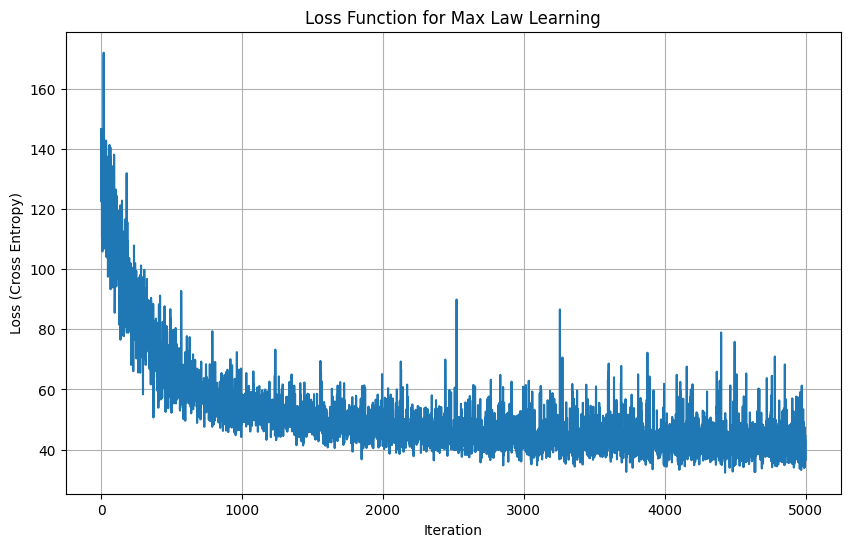

In [7]:
# Training parameters
num_epochs = 40  # Increased number of epochs for better convergence
iterations_per_epoch = max(1, len(data_layer.train_indices) // BATCH_SIZE)
total_iterations = num_epochs * iterations_per_epoch

# We use the train method of NeuralNetwork which displays all necessary information
print(f"Training the network for {num_epochs} epochs ({total_iterations} total iterations)...\n")
net.train(total_iterations)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(net.loss, '-')
plt.title('Loss Function for Max Law Learning')
plt.xlabel('Iteration')
plt.ylabel('Loss (Cross Entropy)')
plt.grid(True)
plt.show()

## 5. Model Evaluation

Test accuracy: 71.25%


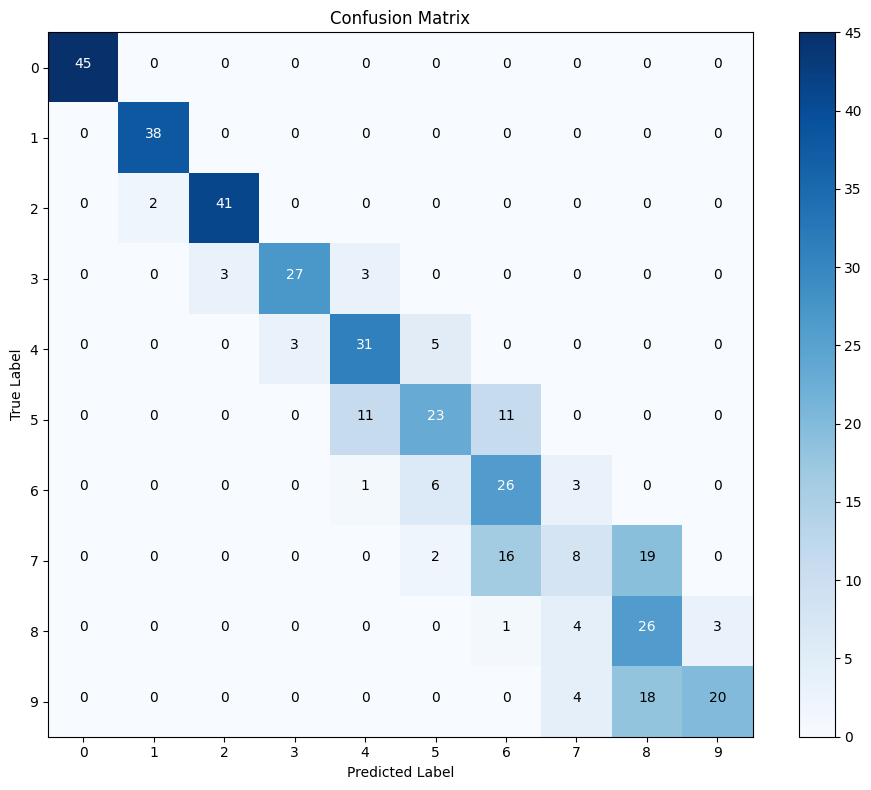

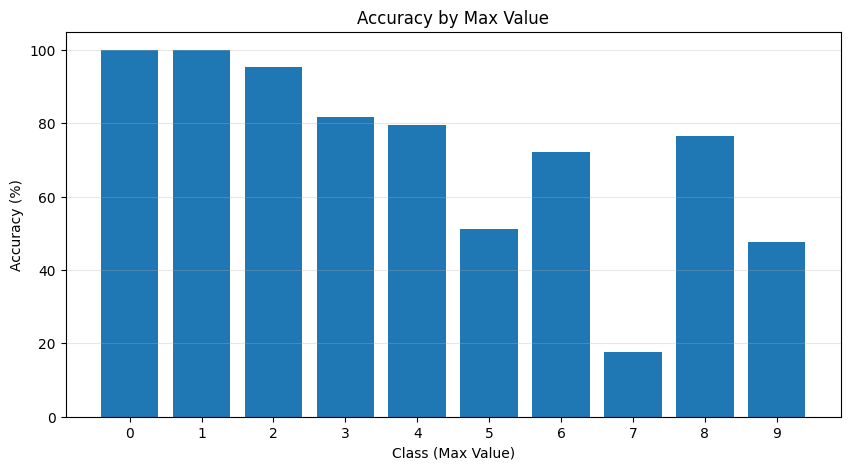

In [8]:
# Evaluation on test set
X_test, y_test = test_data.get_train_set()  # We use get_train_set() since it's the entire test set
y_pred = net.test(X_test)

# Calculate accuracy
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test accuracy: {accuracy:.2f}%")

# Create confusion matrix
confusion = np.zeros((MAX_VALUE, MAX_VALUE), dtype=int)
for i in range(len(true_classes)):
    confusion[true_classes[i], predicted_classes[i]] += 1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(MAX_VALUE)
plt.xticks(tick_marks, range(MAX_VALUE))
plt.yticks(tick_marks, range(MAX_VALUE))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = confusion.max() / 2
for i in range(MAX_VALUE):
    for j in range(MAX_VALUE):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracies = np.zeros(MAX_VALUE)
for i in range(MAX_VALUE):
    if np.sum(true_classes == i) > 0:  # Avoid division by zero
        class_accuracies[i] = np.sum((true_classes == i) & (predicted_classes == i)) / np.sum(true_classes == i) * 100

# Plot per-class accuracy
plt.figure(figsize=(10, 5))
plt.bar(range(MAX_VALUE), class_accuracies)
plt.xlabel('Class (Max Value)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Max Value')
plt.xticks(range(MAX_VALUE))
plt.ylim(0, 105)  # Scale from 0% to 100%
plt.grid(axis='y', alpha=0.3)
plt.show()

## 6. Prediction Visualization

In [9]:
# Display some example predictions
print("\nSome example predictions:")
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    inputs = X_test[idx]
    true_max = np.argmax(y_test[idx])
    pred_max = np.argmax(y_pred[idx])
    correct = true_max == pred_max
    
    # Get confidence (probability) for the prediction
    confidence = y_pred[idx, pred_max] * 100
    
    # Print with color indicator for correct/incorrect predictions
    status = "✓" if correct else "✗"
    print(f"Inputs: {inputs}, True Max: {true_max}, Predicted: {pred_max} ({confidence:.1f}% confidence) {status}")

# Analyze the harder cases (where prediction is wrong)
incorrect_indices = np.where(predicted_classes != true_classes)[0]
if len(incorrect_indices) > 0:
    print("\nAnalyzing some incorrect predictions:")
    for i in range(min(5, len(incorrect_indices))):
        idx = incorrect_indices[i]
        inputs = X_test[idx]
        true_max = true_classes[idx]
        pred_max = predicted_classes[idx]
        
        # Check if there are multiple inputs with values close to the maximum
        max_count = np.sum(inputs == true_max)
        second_max = np.partition(inputs, -2)[-2] if len(inputs) > 1 else -1
        
        print(f"Inputs: {inputs}, True Max: {true_max}, Predicted: {pred_max}")
        print(f"  - Occurrences of max value: {max_count}, Second highest value: {second_max}")
else:
    print("\nNo incorrect predictions found!")


Some example predictions:
Inputs: [2 0 0 0 0], True Max: 2, Predicted: 2 (44.6% confidence) ✓
Inputs: [2 1 1 0 0], True Max: 2, Predicted: 2 (46.9% confidence) ✓
Inputs: [2 0 1 0 3], True Max: 3, Predicted: 3 (42.2% confidence) ✓
Inputs: [4 1 5 0 4], True Max: 5, Predicted: 5 (30.5% confidence) ✓
Inputs: [0 0 0 0 0], True Max: 0, Predicted: 0 (99.3% confidence) ✓
Inputs: [3 2 7 1 6], True Max: 7, Predicted: 6 (26.1% confidence) ✗
Inputs: [1 7 0 4 2], True Max: 7, Predicted: 6 (27.6% confidence) ✗
Inputs: [0 1 0 0 0], True Max: 1, Predicted: 1 (66.4% confidence) ✓
Inputs: [1 2 9 2 3], True Max: 9, Predicted: 7 (25.9% confidence) ✗
Inputs: [1 0 1 0 3], True Max: 3, Predicted: 3 (40.4% confidence) ✓

Analyzing some incorrect predictions:
Inputs: [3 0 3 4 3], True Max: 4, Predicted: 5
  - Occurrences of max value: 1, Second highest value: 3
Inputs: [2 2 3 2 2], True Max: 3, Predicted: 4
  - Occurrences of max value: 1, Second highest value: 2
Inputs: [4 5 1 4 4], True Max: 5, Predicted: 6